In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True)
#dataFrame.show(1)

providing ../data/raw/2022_place_canvas_history-000000000050.csv ...
../data/raw/2022_place_canvas_history-000000000050.csv is already in data/raw
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/vscode/.ivy2/cache
The jars for the packages stored in: /home/vscode/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-35ee327a-a660-4843-8dc1-92c85eedf7de;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 87ms :: artifacts dl 3ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------------

<div style="color:pink">

Idee: 
-Daten nach Nutzern aggregieren und die Zeit zwischen aufeinanderfolgenden Pixeln vergleichen[erledigt] <br>
-Zeit (Differenz) festhalten und mit dem nächsten Zeitraum vergleichen [erledigt] <br>
-Falls die Differenz abweicht, ist der Nutzer wahrscheinlich kein Bot(?) <br>

</div>

In [2]:
import pyspark.sql.functions as F
timeDiffFrame = dataFrame.alias('df1').join(dataFrame.alias('df2'),F.col('df1.user_id') == F.col('df2.user_id'),'inner')
timeDiffFrame = timeDiffFrame.where('df2.t > df1.t')
timeDiffFrame = timeDiffFrame.orderBy(['df1.user_id', 'df1.t'])
timeDiffFrame = timeDiffFrame.select(F.col('df1.user_id'),F.col('df1.t').alias('t1'),F.col('df2.t').alias('t2'),(F.col('df2.t') - F.col('df1.t')).alias('diff'))
#timeDiffFrame.show(15)

<div style ="color:pink">
-Differenz speichern und beim nächsten Vergleich erneut verwenden? [erledigt] <br>
-Nutzer, die das Kriterium bei einem der Vergleiche nicht erfüllen, müssten nicht erneut betrachtet werden(?) <br>
<br>
SELECT user_id, diff <br>
FROM timeDiffFrame <br>
WHERE NOT EXISTS(<br>
   SELECT *<br>
   FROM timeDiffFrame a, timeDiffFrame b<br>
   WHERE a.user_id = b.user_id<br>
   AND a.diff <> b.diff);<br>
</div>

In [3]:
timeDiffReduced = timeDiffFrame.dropDuplicates(['user_id', 't1'])
timeDiffReduced = timeDiffReduced.orderBy(['user_id', 't1'])
#timeDiffReduced.show(15)

In [4]:
botDiff = timeDiffReduced.alias('tdr1').join(timeDiffReduced.alias('tdr2'),F.col('tdr1.user_id') == F.col('tdr2.user_id'),'inner')
botDiff = botDiff.where('tdr1.diff == tdr2.diff').where('tdr1.t2 == tdr2.t1')
botDiff = botDiff.select('tdr1.user_id','tdr1.diff')
botDiff = botDiff.dropDuplicates(['user_id'])
botDiff = botDiff.orderBy(['user_id'])
#botDiff.show(15)
#stuft aktuell Nutzer als Bot ein, wenn 1x die Zeit vom Setzen von Pixel genau nacheinander übereinstimmt
#Beispiel: Pixel 2 - Pixel 1 == 300 && Pixel 4 - Pixel 3 == 300
#die Zeiträume müssen wirklich direkt aneinander anknüpfen
#die Berechnung ist m.M.n close enough
#eventuell versuche ich, das Ganze nochmal präziser zu gestalten

In [5]:
print(botDiff.count())

22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:35 WARN RowBasedKeyValueBatch: Calling spill() on

14132


<div style="color:pink">
Als Nächstes will ich versuchen, eine Grafik zu den meistgenutzen Farben der Bots zu erstellen <br>
Dazu klaue ich einfach Nicoles Vorlage :)
</div>

In [6]:
colorFrame = dataFrame.alias('df').join(botDiff.alias('bd'),F.col('df.user_id') == F.col('bd.user_id'), 'inner')
colorFrame = colorFrame.select(['df.user_id',('df.pixel_color'),'t'])
colorFrame = colorFrame.dropDuplicates(['user_id', 't']) #wir filtern nach t, da ein Nutzer keine zwei Pixel gleichzeitig setzen kann
colorFrame = colorFrame.orderBy(['user_id'])
#colorFrame.printSchema()
#colorFrame.show(20) 
#die vorher bestimmten Bots sind jetzt einzeln gelistet mit ihren gesetzten Pixeln


In [7]:
from src.features.feature_functions import group_dataframe_by_color
groupedFrame = group_dataframe_by_color(colorFrame)
groupedFrame = groupedFrame.drop('collect_list(t)', 'collect_list(user_id)')
#groupedFrame.show(10)
dataCollect = groupedFrame.head(5)


22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:48:53 WARN RowBasedKeyValueBatch: Calling spill() on

+-----------+-----+
|pixel_color|count|
+-----------+-----+
|    #000000|26115|
|    #FFFFFF|18627|
|    #2450A4| 7736|
|    #FF4500| 6819|
|    #BE0039| 6365|
|    #FFD635| 6182|
|    #51E9F4| 5675|
|    #3690EA| 4403|
|    #FFA800| 4379|
|    #D4D7D9| 3406|
+-----------+-----+
only showing top 10 rows



22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/06/13 07:49:11 WARN RowBasedKeyValueBatch: Calling spill() on

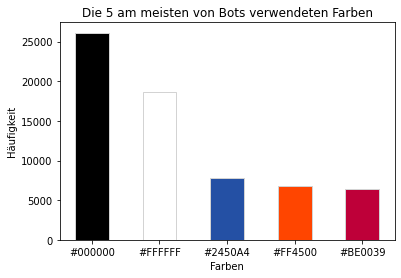

In [8]:
from src.visualization.visuialization_functions import show_and_save
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots()
for row in dataCollect:
    pixel_color,count = list(row)
    plt.bar(pixel_color,count,color = pixel_color, edgecolor = 'lightgrey', width=0.5)
plt.title('Die 5 am meisten von Bots verwendeten Farben')
plt.ylabel('Häufigkeit')
plt.xlabel('Farben')
show_and_save(plt, 'top5_genutze_Farben_bots')

<div style=color:pink>
ab hier folgen Funktionen zu den meistumkämpften Pixeln :))
</div>

In [9]:
from src.features.feature_functions import group_dataframe_by_pixel
pixelFrame = dataFrame.alias('df').join(botDiff.alias('bd'),F.col('df.user_id') == F.col('bd.user_id'), 'inner')
pixelFrame = pixelFrame.select('df.user_id', 'x', 'y')
pixelFrame = pixelFrame.orderBy('user_id')

ImportError: cannot import name 'group_dataframe_by_pixel' from 'src.features.feature_functions' (/workspaces/placegroups/src/features/feature_functions.py)